In [14]:
# %%
# ==========================================
# PHASE III: CLASSIFICATION
# CHUNK 0: Data Loading & Logic
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

SAMPLE_SIZE = 100000 
df_flights = pd.read_csv('US_flights_2023.csv', low_memory=False)
df_tiers = pd.read_csv('airport_performance_tiers_enriched.csv')
df_weather = pd.read_csv('weather_meteo_by_airport.csv')
df_flights['FlightDate'] = pd.to_datetime(df_flights['FlightDate'])
df_weather['time'] = pd.to_datetime(df_weather['time'])


# Merge A: Add Tiers (Risk Profiles)
df_merged = df_flights.merge(
    df_tiers[['Dep_Airport', 'Performance_Tier']], 
    on='Dep_Airport', 
    how='left'
)

# Merge B: Add Weather (Rain/Snow/Wind)
df_final = df_merged.merge(
    df_weather[['airport_id', 'time', 'prcp', 'snow', 'wspd', 'tmin']],
    left_on=['Dep_Airport', 'FlightDate'],
    right_on=['airport_id', 'time'],
    how='left'
)

dest_counts = df_final['Arr_Airport'].value_counts()
df_final['Dest_Volume'] = df_final['Arr_Airport'].map(dest_counts)

# Define Target: 0 = OnTime, 1 = Delayed (>15 mins)
df_final['Target_Class'] = (df_final['Dep_Delay'] >= 15).astype(int)

df_final['Performance_Tier'] = df_final['Performance_Tier'].fillna(-1).astype(int)
print(f"Dataset Built. Shape: {df_final.shape}")

Dataset Built. Shape: (6743404, 33)


In [ ]:
# %%
# ==========================================
# CHUNK 1: Feature Engineering
# ==========================================
print("--- preparing Training Data ---")

features = [
    # Operational
    'Day_Of_Week', 'DepTime_label', 'Airline', 'Flight_Duration', 'Aicraft_age',
    # Location Risk (From Clustering)
    'Performance_Tier', 'Dest_Volume',
    # Weather Triggers
    'prcp', 'snow', 'wspd', 'tmin'
]

df_cls = df_final[features + ['Target_Class']].dropna()

print("Class Balance (Original):")
print(df_cls['Target_Class'].value_counts(normalize=True))

if len(df_cls) > SAMPLE_SIZE:
    df_cls = df_cls.sample(n=SAMPLE_SIZE, random_state=42)

X = df_cls[features].copy()
y = df_cls['Target_Class']

# Label Encode 'Airline' and 'DepTime_label'
le = LabelEncoder()
X['Airline'] = le.fit_transform(X['Airline'].astype(str))
X['DepTime_label'] = le.fit_transform(X['DepTime_label'].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
print("Data Ready for Modeling.")

--- preparing Training Data ---
Class Balance (Original):
Target_Class
0    0.574348
1    0.425652
Name: proportion, dtype: float64
Encoding Categoricals...
Scaling Data...
Data Ready for Modeling.


In [ ]:
# ==========================================
# CHUNK 2: Training Models and Evaluation
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import pandas as pd

# Defines all models to be trained
models = {
    
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),

    "Naïve Bayes": GaussianNB(),
    
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=500, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', max_iter=2000, random_state=42),
    
    "Stacking Classifier": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)),
            ('svr', SVC(kernel='rbf', probability=True, max_iter=1000, random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

results = {}

print(f"--- Training {len(models)} Models ---")

for name, model in models.items():
    print(f"Running {name}...")
    try:
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.decision_function(X_test)
            
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        # Precision (PPV) & Recall (Sensitivity) for Class 1 (Delayed)
        prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        
        # Specificity (True Negative Rate) -> Recall of Class 0 (On Time)
        spec = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
        
        results[name] = {
            "AUC": auc, 
            "Precision": prec, 
            "Recall": rec,
            "Specificity": spec,
            "Accuracy": acc,
            "Probs": y_prob 
        }
        print(f"   -> AUC: {auc:.3f} | Recall (Sens): {rec:.2f} | Specificity: {spec:.2f}")
        
    except Exception as e:
        print(f"   -> Failed: {e}")

print("\nAll Models Trained.")

print("\n" + "="*50)
print("FINAL PERFORMANCE REPORT")
print("="*50)


# Create DataFrame and sort by AUC
report_df = pd.DataFrame(results).T[['AUC', 'Precision', 'Recall', 'Specificity']]
report_df = report_df.sort_values('AUC', ascending=False)

print(report_df.round(2))
print("="*50)

--- Training 10 Models (Please Wait) ---
Running Logistic Regression...
   -> AUC: 0.616 | Recall (Sens): 0.31 | Specificity: 0.82
Running LDA...
   -> AUC: 0.616 | Recall (Sens): 0.31 | Specificity: 0.82
Running Decision Tree...
   -> AUC: 0.654 | Recall (Sens): 0.47 | Specificity: 0.75
Running Random Forest...
   -> AUC: 0.681 | Recall (Sens): 0.42 | Specificity: 0.82
Running Gradient Boosting...
   -> AUC: 0.679 | Recall (Sens): 0.43 | Specificity: 0.81
Running Naïve Bayes...
   -> AUC: 0.609 | Recall (Sens): 0.22 | Specificity: 0.86
Running KNN...
   -> AUC: 0.589 | Recall (Sens): 0.44 | Specificity: 0.69
Running Neural Network...
   -> AUC: 0.669 | Recall (Sens): 0.46 | Specificity: 0.77
Running SVM...


c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   -> AUC: 0.538 | Recall (Sens): 0.30 | Specificity: 0.75
Running Stacking Classifier...


c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1

   -> AUC: 0.665 | Recall (Sens): 0.40 | Specificity: 0.81

All Models Trained.

FINAL PERFORMANCE REPORT
                          AUC Precision    Recall Specificity
Random Forest        0.680915  0.632659  0.415395    0.822049
Gradient Boosting    0.679169  0.625408  0.433673    0.808355
Neural Network       0.669044  0.600419  0.458828    0.774712
Stacking Classifier  0.665342  0.615363   0.40456     0.81343
Decision Tree          0.6544  0.581347  0.470982    0.749757
Logistic Regression  0.616409  0.555992  0.306859    0.819199
LDA                  0.616366  0.555327  0.305446    0.819547
Naïve Bayes          0.609307      0.55  0.224892    0.864243
KNN                  0.588957  0.513747  0.441869    0.691436
SVM                  0.537601  0.463948  0.295836     0.74781


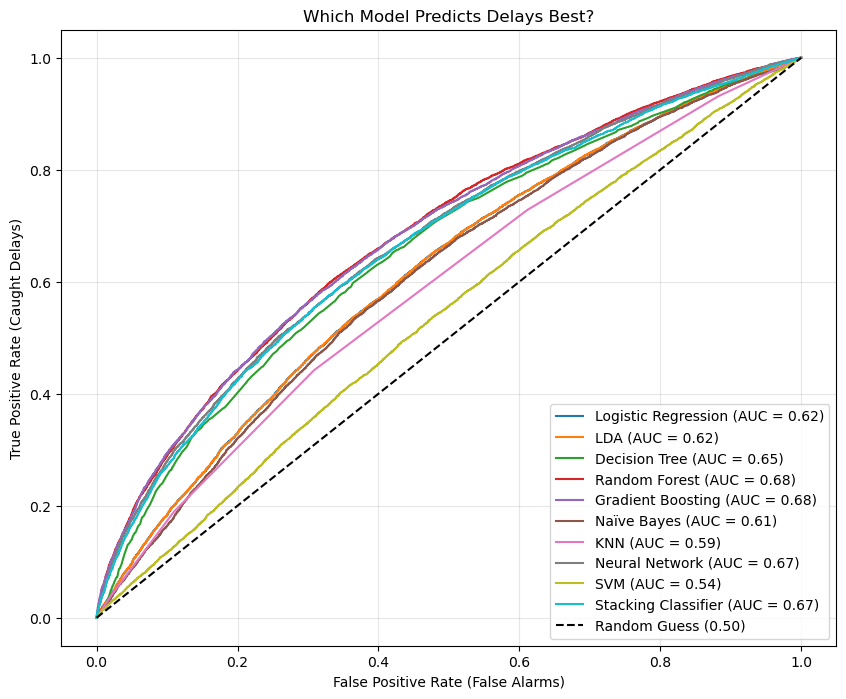


--- FINAL MODEL LEADERBOARD ---
                    Accuracy       AUC
Random Forest         0.6494  0.680915
Gradient Boosting    0.64928  0.679169
Neural Network        0.6406  0.669044
Stacking Classifier  0.63984  0.665342
Decision Tree         0.6314    0.6544
Logistic Regression  0.60168  0.616409
LDA                  0.60128  0.616366
Naïve Bayes           0.5928  0.609307
KNN                  0.58548  0.588957
SVM                  0.55592  0.537601


In [6]:
# %%
# ==========================================
# CHUNK 3: ROC Curve Comparison
# ==========================================
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, data in results.items():
    fpr, tpr, _ = roc_curve(y_test, data["Probs"])
    auc_score = data["AUC"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (0.50)')

plt.title('Which Model Predicts Delays Best?')
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Caught Delays)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Print Leaderboard
leaderboard = pd.DataFrame(results).T[['Accuracy', 'AUC']].sort_values('AUC', ascending=False)
print("\n--- FINAL MODEL LEADERBOARD ---")
print(leaderboard)

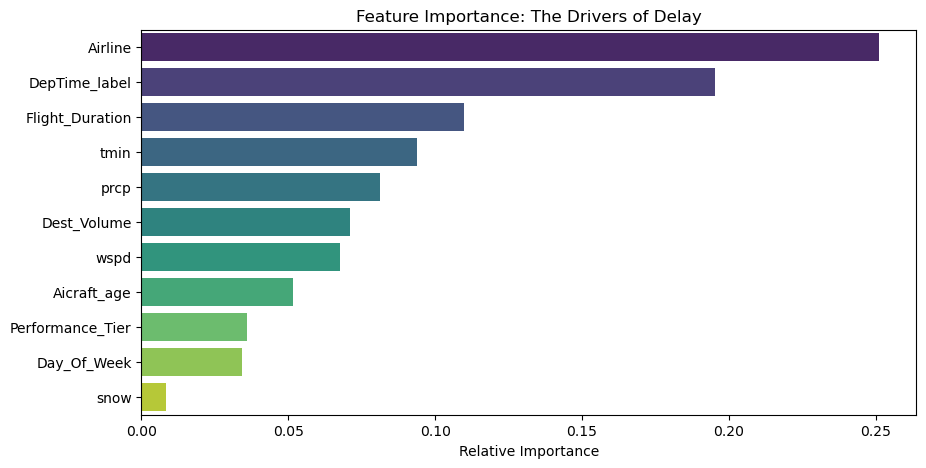

In [16]:
# %%
# ==========================================
# CHUNK 4: What Drives Delays?
# ==========================================
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance: The Drivers of Delay")
sns.barplot(
    x=importances[indices], 
    y=[features[i] for i in indices], 
    hue=[features[i] for i in indices], 
    legend=False,                       
    palette='viridis'
)
plt.xlabel('Relative Importance')
plt.show()

--- Airline Delay Rates (Worst to Best) ---
                         Airline  Delay_Rate
8                JetBlue Airways    0.313293
6         Frontier Airlines Inc.    0.312448
13              Spirit Air Lines    0.295096
12        Southwest Airlines Co.    0.246405
1                  Allegiant Air    0.236854
2         American Airlines Inc.    0.220197
7         Hawaiian Airlines Inc.    0.203765
14         United Air Lines Inc.    0.199251
0           Alaska Airlines Inc.    0.177265
4            Delta Air Lines Inc    0.171075
3   American Eagle Airlines Inc.    0.156074
9                   PSA Airlines    0.145929
11         Skywest Airlines Inc.    0.142961
5                   Endeavor Air    0.133399
10              Republic Airways    0.107581


C:\Users\gmatt\AppData\Local\Temp\ipykernel_46776\4288420050.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


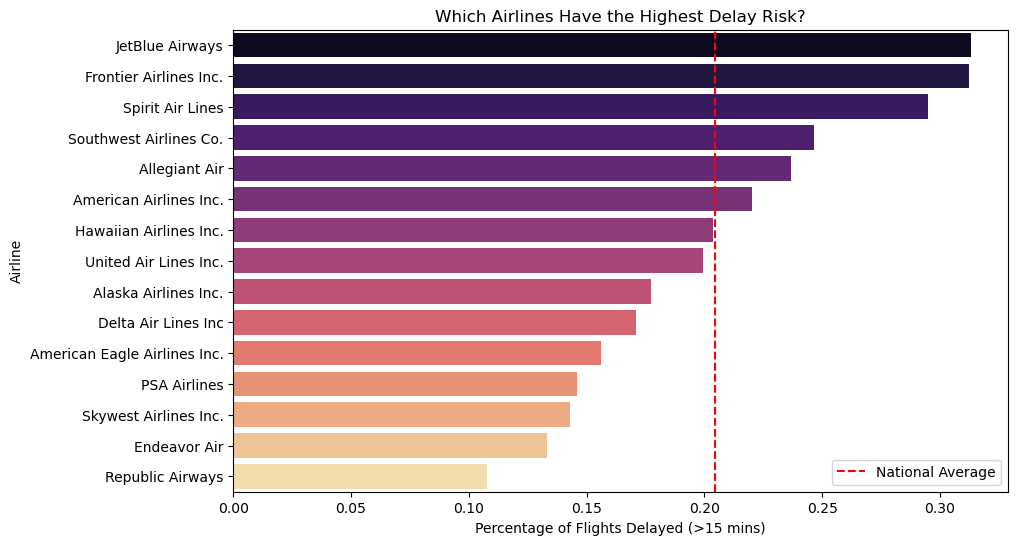

In [17]:
# %%
# ==========================================
# CHUNK 5: Airline Performance Audit
# ==========================================


airline_perf = df_final.groupby('Airline')['Target_Class'].mean().reset_index()
airline_perf.columns = ['Airline', 'Delay_Rate']

airline_perf = airline_perf.sort_values('Delay_Rate', ascending=False)

print("--- Airline Delay Rates (Worst to Best) ---")
print(airline_perf)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Delay_Rate', 
    y='Airline', 
    data=airline_perf, 
    palette='magma'
)
plt.axvline(df_final['Target_Class'].mean(), color='red', linestyle='--', label='National Average')
plt.title('Which Airlines Have the Highest Delay Risk?')
plt.xlabel('Percentage of Flights Delayed (>15 mins)')
plt.legend()
plt.show()

C:\Users\gmatt\AppData\Local\Temp\ipykernel_46776\1518584111.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time_Block', y='Delay_Probability', data=time_risk, palette='rocket_r')


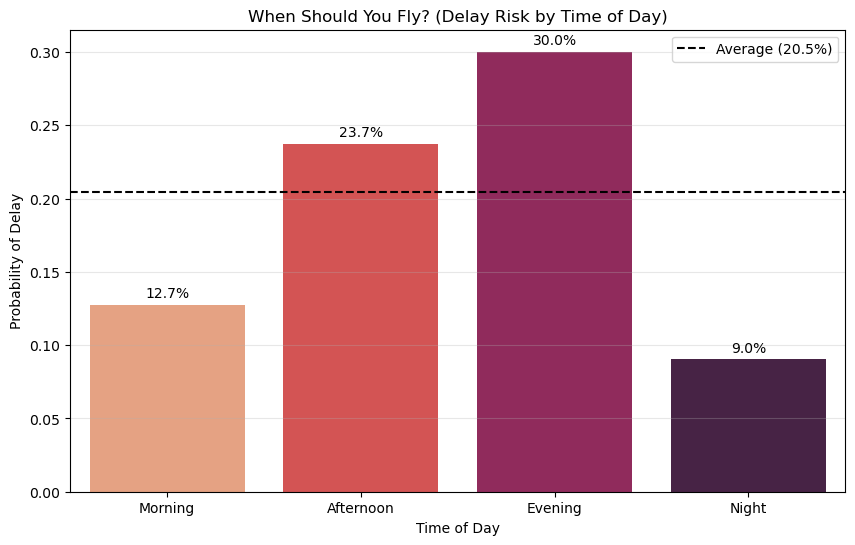

In [ ]:
# %%
# ==========================================
# CHUNK 6: The "Time of Day" Risk
# ==========================================

time_risk = df_final.groupby('DepTime_label')['Target_Class'].mean().reset_index()
time_risk.columns = ['Time_Block', 'Delay_Probability']


custom_order = ['Morning', 'Afternoon', 'Evening', 'Night']
if set(time_risk['Time_Block'].unique()).issubset(set(custom_order)):
    time_risk['Time_Block'] = pd.Categorical(time_risk['Time_Block'], categories=custom_order, ordered=True)
    time_risk = time_risk.sort_values('Time_Block').reset_index(drop=True)
else:
    time_risk = time_risk.sort_values('Delay_Probability').reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Time_Block', y='Delay_Probability', data=time_risk, palette='rocket_r')

avg_delay = df_final['Target_Class'].mean()
plt.axhline(avg_delay, color='black', linestyle='--', label=f'Average ({avg_delay:.1%})')

plt.title('When Should You Fly? (Delay Risk by Time of Day)')
plt.ylabel('Probability of Delay')
plt.xlabel('Time of Day')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for index, row in time_risk.iterrows():
    plt.text(index, row.Delay_Probability + 0.005, f'{row.Delay_Probability:.1%}', 
             color='black', ha="center")

plt.show()